# Week 6 ex 1
## CMB Map

## Install of CoLab Dependencies

## Real Code

In [1]:
import healpy as hp
from healpy.newvisufunc import projview, newprojplot

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [3]:
m = hp.read_map("COM_CMB_IQU-commander_2048_R3.00_full.fits",field=5);

print(type(m))
print(m.ndim,m.shape,m.size)

<class 'numpy.ndarray'>
1 (50331648,) 50331648


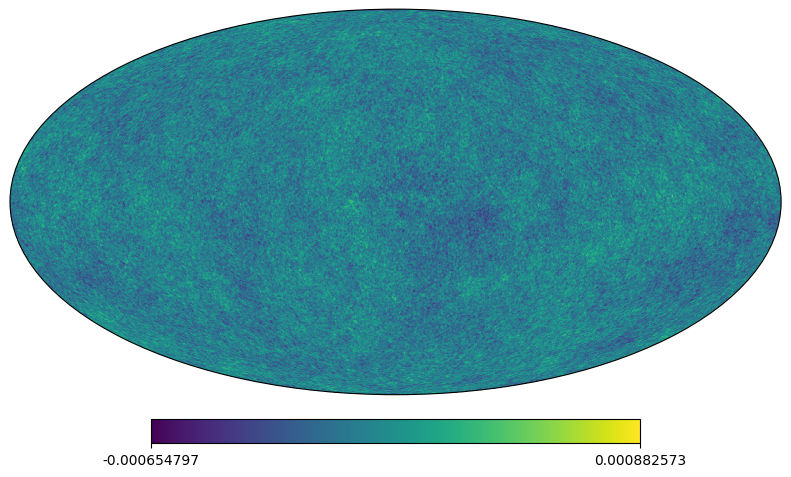

In [4]:
# classic healpy mollweide projections plot
# other matplotlib projections are possible, such as: "aitoff","hammer",lambert"
projview(m, coord=["G"], flip="astro", projection_type="mollweide");

Let's print the mean and variance of the map (that is of the array m).
The mean is almost 0

In [5]:
m_mean=np.mean(m)
m_var=np.var(m)

print('mean=',m_mean,'var=',m_var)

mean= -2.1594802e-07 var= 1.1614195e-08


Let's plot the histo of the map. It looks pretty gaussian to me.

In [ ]:
plt.hist(m,bins=100)
plt.title('Planck Map Histo')
plt.xlabel('$\delta T / T $')

let's compute higher moments of the data distribution

In [ ]:
skew=stats.skew(m)
curt=stats.kurtosis(m)

print('skew=',skew)
print('curt=',curt)

### Power Spectrum: $a_{lm}$

We now want to compute the power spectrum of the map, that is

 $ \delta(\vec{r})=\sum_{l,m} a_{lm} Y^l_m $

 $ a_{lm}=\int d\phi\int d\cos\theta \ \  Y^*_{lm}(\theta,\phi) \delta(\vec{r}) $

 healpy function map2alm takes the array representing the map and computes the spherical harmonics decomposition (that is the $ a_{lm}$ )

In [ ]:
##computing a_lm
LMAX = 3000                    ##sets the max multipole moment
a_lm = hp.map2alm(m,LMAX)
print(a_lm.shape)

Let us plot the histogram of the a_lm as a function of m for l=5 and l=500. We use the function

healpy.sphtfunc.Alm.getidx (lmax,l,m)

which returns index corresponding to (l,m) in an array describing alm up to lmax.
See https://healpy.readthedocs.io/en/latest/generated/healpy.sphtfunc.Alm.getidx.html

Nota: resituisce solo quelli con m>0, per risparmiare un fattore 2 di memoria. Quelli con m<0 li calcolo sfruttando il fatto che il campo di fluttuazioni di temperatura è reale, peciò vale:

$ a_{l,-m}=(-1)^m a_{l,m}^* $

#### $a_{lm}$ with l=5

In [ ]:
##create array with a_5,m
l=5
a_5m=[]
for i in range(-l,l+1):              ##range stop is not included
    index = hp.sphtfunc.Alm.getidx(LMAX,l,abs(i))
    if i>0:
        a_5m.append(a_lm[index])
    else:
        appo=((-1)**i)*np.conjugate(a_lm[index])
        a_5m.append(appo)
a_5m=np.array(a_5m)

print(len(a_5m))                     ##debug:should be 2l+1

In [ ]:
plt.figure(figsize=(9,3))
plt.subplot(131)
fig=plt.hist(a_5m.real,bins=20)
fig=plt.title('$Re(a_{lm})$')
plt.subplot(133)
fig=plt.hist(a_5m.imag,bins=20)
fig=plt.title('$Im(a_{lm})$')

I do not have enough statistics to have an idea of the distribution of the $a_{lm}$

#### $a_{lm}$ with l=500

In [ ]:
##create array with a_500,m
l=500
a_500m=[]
for i in range(-l,l+1):             ##range stop is not included
    index=hp.sphtfunc.Alm.getidx(LMAX,l,abs(i))
    if i>0:
        a_500m.append(a_lm[index])
    else:
        appo=((-1)**i)*np.conjugate(a_lm[index])
        a_500m.append(appo)
a_500m=np.array(a_500m)
print(len(a_500m))                 ##debug:should be 2l+1

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(131)
fig=plt.hist(a_500m.real,bins=20)
fig=plt.title('$Re(a_{lm})$')
plt.subplot(132)
fig=plt.hist(a_500m.imag, bins=20)
fig=plt.title('$Im(a_{lm})$')

Here I have enough statistics to fit the histo with a distribution. It is almost gaussian with a little positive skewness.

### Power Spectrum: $C_l$

#### $C_l$ from $a_{lm}$

Let us average over m for all the fixed values of l to get the $C_l$ from the $a_{lm}$, that is

$ <a_{lm}^*a_{l'm'}>=\delta_{ll'}\delta_{mm'}C_l $
but $ a_{l,m}=a_{l,m}* $ thus $ <a_{lm}^*a_{l'm'}>= < |a_{lm}|^2 > $

$ C_l=\frac{1}{2l+1}\sum_m |a_{lm}|^2 $

In [ ]:
c_l=[]
for l in range(0,LMAX+1):
    a2=[]
    alm2=0
    for i in range(-l,l+1):
        index=hp.sphtfunc.Alm.getidx(LMAX,l,abs(i))
        if i>0:
            appo=a_lm[index]
        else:
            appo=((-1)**i)*np.conjugate(a_lm[index])
        alm2+=appo*np.conjugate(appo)
    alm2=alm2/(2*l+1)
    c_l.append(alm2.real)

c_l=np.array(c_l)
print(c_l.shape)

In [ ]:
ell = np.arange(len(c_l))

plt.title('power spectrum from $a_{lm}$')
plt.plot(ell,ell*(ell+1)*c_l*1e12)
plt.xlabel("$\ell$")
plt.ylabel("$\ell(\ell+1)C_{\ell}$")

#### $C_l$ from healpy anafast function

healpy function anafast takes the array representing the map and computes the power spectrum.


In [ ]:
##computing power spectrum up to l=LMAX
cl = hp.anafast(m, lmax=LMAX)
ell = np.arange(len(cl))
print(cl.shape)

In [ ]:
##plotting power spectrum
plt.title('power spectrum from anafast')
plt.plot(ell, ell * (ell + 1) * cl*1e12)
plt.xlabel("$\ell$")
plt.ylabel("$\ell(\ell+1)C_{\ell}$")
#plt.grid()
#hp.write_cl("cl.fits", cl, overwrite=True)

We now compute the difference between the two spectra: it's less than machine precision, that is it IS zero.

In [ ]:
plt.title('difference between the two spectra')
plt.plot(ell, ell*(ell+1)*(cl-c_l))
plt.xlabel("$\ell$")
plt.ylabel("$\ell(\ell+1)C_{\ell}$")

### Angular correlation function

$\omega(\theta)=\frac{1}{4\pi}\sum_l (2l+1) c_l P_l(cos\theta)$

In [ ]:
from scipy.special import eval_legendre

In [ ]:
def angular_corr_func(theta,l_max,c_l):
    omega=[]

    for t in theta:
        Om_l=0
        for l in range(0,l_max):
            Om_l+=(2*l+1)*c_l[l]*eval_legendre(l,np.cos(t))/(4*np.pi)
        omega.append(Om_l)
    return omega

In [ ]:
theta=np.linspace(0.0,np.pi,num=1000)
omega=angular_corr_func(theta, LMAX, cl*1e12)


In [ ]:
plt.plot(theta,omega)
plt.xlabel('$\\theta$')
plt.ylabel('$ \omega(\\theta) $')
ticks=[0,0.5*np.pi,np.pi]
ticks_label=[f'${i/2}\pi$' for i in range(0,len(ticks))]
plt.xticks(ticks,ticks_label)
plt.hlines(0,0,np.pi,'orange')
plt.ylim(-300,400)

Let us check the integral constraint, that is $\int \omega(\theta) d\theta=0$

In [ ]:
print(np.trapz(omega[0:220], theta[0:220]))
print(np.trapz(omega[220:500], theta[220:500]))
print(np.trapz(omega[500:], theta[500:]))
print(np.trapz(omega, theta))

### Image Downgrade

In [ ]:
NSIDE=32
m_down=hp.pixelfunc.ud_grade(m,NSIDE)   ##downgraded CMB map

pixeldim=hp.pixelfunc.nside2resol(NSIDE, arcmin=True)/60
print('the dimension of a single pixel is ', pixeldim, 'degrees')
pixelarea=hp.pixelfunc.nside2pixarea(NSIDE,degrees=True)
print('the area of a single pixel is ', pixelarea, 'squared degrees')

Basically it means that each pixel covers approximately one horizon, thus we can reasonably assume that each pixel is independent from the others, since it had not been in causal contact with the others before at the time of the last scattering.

In [ ]:
projview(m_down, coord=["G"], flip="astro", projection_type="mollweide");

In [ ]:
cl_down = hp.anafast(m_down, lmax=LMAX)
ell_down = np.arange(len(cl))

In [ ]:
##plotting power spectrum
plt.title('power spectrum from anafast')
plt.plot(ell_down, ell_down * (ell_down + 1) * cl_down,label='downgraded')
plt.plot(ell, ell * (ell + 1) * cl,label='original')
plt.xlabel("$\ell$")
plt.ylabel("$\ell(\ell+1)C_{\ell}$")
plt.legend()

Diventa tutto periodico perché ho tagliato via le piccole scale (come quando fai una trasformata di Fourier di una funzione con supporto limitato: viene tutto esteso con periodicità)

Ricavare lmax corrispondente a 1.8 gradi (la dim del pixel) e buttare via tutti gli lmax maggiori

Replot the same plot but cutting at LMAX given by the pizel size

In [ ]:
LMAX=350

##plotting power spectrum
plt.title('power spectrum from anafast')
plt.plot(ell_down[:LMAX], ell_down[:LMAX] * (ell_down[:LMAX] + 1) * cl_down[:LMAX],label='downgraded')
#plt.plot(ell[:LMAX], ell[:LMAX] * (ell[:LMAX] + 1) * cl[:LMAX],label='original')
plt.xlabel("$\ell$")
plt.ylabel("$\ell(\ell+1)C_{\ell}$")
plt.legend()

In [ ]:
theta=np.linspace(0.0,np.pi,num=1000)
omega_down=angular_corr_func(theta, LMAX, cl_down[:LMAX]*1e12)

In [ ]:
plt.plot(theta,omega_down)
plt.xlabel('$\\theta$')
plt.ylabel('$ \omega(\\theta) $')
ticks=[0,0.5*np.pi,np.pi]
ticks_label=[f'${i/2}\pi$' for i in range(0,len(ticks))]
plt.xticks(ticks,ticks_label)
plt.hlines(0,0,np.pi,'orange')
#plt.ylim(-300,400)

### Image Smoothing

Smoothing takes A LOT of time (at least on my old 2011 MacBookPro)

Also on MacBookAir2020 on Colab

Gotta try locally on MacBookAir

In [ ]:
#NSIDE=getnside(m)
smooth_aperture=hp.pixelfunc.nside2resol(NSIDE)
m_smooth=hp.sphtfunc.smoothing(m, sigma=smooth_aperture)

In [ ]:
projview(m_smooth, coord=["G"], flip="astro", projection_type="mollweide");

In [ ]:
cl_smooth = hp.anafast(m_smooth, lmax=LMAX)
ell_smooth = np.arange(len(cl))

In [ ]:
LMAX=350
##plotting power spectrum
plt.title('power spectrum from anafast')
plt.plot(ell_smooth[:LMAX], ell_smooth[:LMAX] * (ell_smooth[:LMAX] + 1) * cl_smooth[:LMAX],label='smoothed')
#plt.plot(ell, ell * (ell + 1) * cl,label='original')
plt.xlabel("$\ell$")
plt.ylabel("$\ell(\ell+1)C_{\ell}$")
plt.legend()

Se uso un kernel gaussiano invece non ho il prolungamento periodico: il kernel non taglia niente, manda solo a zero l'informazione relativa alle piccole scale, senza però modificare il supporto della funzione di cui calcolo la trasformata.

In [ ]:
theta=np.linspace(0.0,np.pi,num=1000)
omega_smooth=angular_corr_func(theta, LMAX, cl_smooth[:LMAX]*1e12)

In [ ]:
plt.plot(theta,omega_smooth)
plt.xlabel('$\\theta$')
plt.ylabel('$ \omega(\\theta) $')
ticks=[0,0.5*np.pi,np.pi]
ticks_label=[f'${i/2}\pi$' for i in range(0,len(ticks))]
plt.xticks(ticks,ticks_label)
plt.hlines(0,0,np.pi,'orange')
#plt.ylim(-300,400)